In [281]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (8,4)

In [282]:
bankDataRaw = pd.read_csv("bank-full.csv")
bankDataRaw.head(15) #several missing values!

age           job   marital  education default  balance housing loan  \
0    58    management   married   tertiary      no     2143     yes   no   
1    44    technician    single  secondary      no       29     yes   no   
2    33  entrepreneur   married  secondary      no        2     yes  yes   
3    47   blue-collar   married    unknown      no     1506     yes   no   
4    33       unknown    single    unknown      no        1      no   no   
5    35    management   married   tertiary      no      231     yes   no   
6    28    management    single   tertiary      no      447     yes  yes   
7    42  entrepreneur  divorced   tertiary     yes        2     yes   no   
8    58       retired   married    primary      no      121     yes   no   
9    43    technician    single  secondary      no      593     yes   no   
10   41        admin.  divorced  secondary      no      270     yes   no   
11   29        admin.    single  secondary      no      390     yes   no   
12   53    technician   married  secondary      no        6     yes   no   
13   58    technician   married    unknown      no       71     yes   no   
14   57      services   married  secondary      no      162     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome Target  
0   unknown    5   may       261         1     -1         0  unknown     no  
1   unknown    5   may       151         1     -1         0  unknown     no  
2   unknown    5   may        76         1     -1         0  unknown     no  
3   unknown    5   may        92         1     -1         0  unknown     no  
4   unknown    5   may       198         1     -1         0  unknown     no  
5   unknown    5   may       139         1     -1         0  unknown     no  
6   unknown    5   may       217         1     -1         0  unknown     no  
7   unknown    5   may       380         1     -1         0  unknown     no  
8   unknown    5   may        50         1     -1         0  unknown     no  
9   unknown    5   may        55         1     -1         0  unknown     no  
10  unknown    5   may       222         1     -1         0  unknown     no  
11  unknown    5   may       137         1     -1         0  unknown     no  
12  unknown    5   may       517         1     -1         0  unknown     no  
13  unknown    5   may        71         1     -1         0  unknown     no  
14  unknown    5   may       174         1     -1         0  unknown     no

In [283]:
bankDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [284]:
bankDataRaw.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
Target          2
dtype: int64

In [285]:
#At least no nulls to fix
bankDataRaw.isnull().sum().sort_values(ascending = False)

Target       0
loan         0
job          0
marital      0
education    0
default      0
balance      0
housing      0
contact      0
poutcome     0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
age          0
dtype: int64

In [286]:
#Listing all the unique values from the object columns to have an idea of their data
for column in bankDataRaw.columns:
    if bankDataRaw[column].dtype == 'object':
        print(column + ' values\n')
        print(bankDataRaw[column].value_counts())
        print()

job values

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

marital values

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

education values

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

default values

no     44396
yes      815
Name: default, dtype: int64

housing values

yes    25130
no     20081
Name: housing, dtype: int64

loan values

no     37967
yes     7244
Name: loan, dtype: int64

contact values

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

month values

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      

## From this point I can see many points to clear

#### 1. Object types to Categorical
#### 2. Job to dummies
#### 3. Marital to dummies
#### 4. Education will be replaced by a sequencial values to translate the level into numbers (unknow -1 )
#### 5. Default to uint
#### 6. Housing to uint
#### 7. Loan to uint
#### 8. Contact to dummies
#### 9. Month to dummies
#### 10. Poutcome to dummies
#### 11. Target to uint

### All Dummies unknow values will be treat as an exception of all options and be excluded from the columns in other words, all dummies 0 equals to unknows


# Preparing the Data

In [287]:
# Lists of pieces that will be treat differently
listBool = ['default', 'housing' , 'loan', 'Target']
listDummies = ['job', 'marital', 'contact', 'month', 'poutcome']
educationLevels = { 'unknown' : -1, 'primary' : 1, 'secondary' :2, 'tertiary' : 3 }

bankDataCooked = bankDataRaw.copy()

In [288]:
bankDataCooked['education'].replace(educationLevels, inplace=True)
bankDataCooked['education'] = bankDataCooked['education'].astype('int64')

In [289]:
# I almost turned then into boolean, but I decide for copy a dummy output
for column in listBool:
    bankDataCooked[column].replace({'yes': 1, 'no' : 0}, inplace=True)
    bankDataCooked[column] = bankDataCooked[column].astype('uint8')

In [290]:
for column in bankDataCooked.columns:
    if bankDataCooked[column].dtype == 'object':
        bankDataCooked[column] = pd.Categorical(bankDataCooked[column])

In [291]:
bankDataCooked = pd.get_dummies(bankDataCooked, columns=listDummies)

for column in listDummies:
    if (column + '_unknown') in bankDataCooked:
        del bankDataCooked[column +'_unknown'] #Deleting the unknown dummies

In [292]:
bankDataCooked.head()

age  education  default  balance  housing  loan  day  duration  campaign  \
0   58          3        0     2143        1     0    5       261         1   
1   44          2        0       29        1     0    5       151         1   
2   33          2        0        2        1     1    5        76         1   
3   47         -1        0     1506        1     0    5        92         1   
4   33         -1        0        1        0     0    5       198         1   

   pdays  ...  month_jul  month_jun  month_mar  month_may  month_nov  \
0     -1  ...          0          0          0          1          0   
1     -1  ...          0          0          0          1          0   
2     -1  ...          0          0          0          1          0   
3     -1  ...          0          0          0          1          0   
4     -1  ...          0          0          0          1          0   

   month_oct  month_sep  poutcome_failure  poutcome_other  poutcome_success  
0          0          0                 0               0                 0  
1          0          0                 0               0                 0  
2          0          0                 0               0                 0  
3          0          0                 0               0                 0  
4          0          0                 0               0                 0  

[5 rows x 43 columns]

In [293]:
bankDataCooked.describe()

age     education       default        balance       housing  \
count  45211.000000  45211.000000  45211.000000   45211.000000  45211.000000   
mean      40.936210      2.019442      0.018027    1362.272058      0.555838   
std       10.618762      0.902795      0.133049    3044.765829      0.496878   
min       18.000000     -1.000000      0.000000   -8019.000000      0.000000   
25%       33.000000      2.000000      0.000000      72.000000      0.000000   
50%       39.000000      2.000000      0.000000     448.000000      1.000000   
75%       48.000000      3.000000      0.000000    1428.000000      1.000000   
max       95.000000      3.000000      1.000000  102127.000000      1.000000   

               loan           day      duration      campaign         pdays  \
count  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000   
mean       0.160226     15.806419    258.163080      2.763841     40.197828   
std        0.366820      8.322476    257.527812      3.098021    100.128746   
min        0.000000      1.000000      0.000000      1.000000     -1.000000   
25%        0.000000      8.000000    103.000000      1.000000     -1.000000   
50%        0.000000     16.000000    180.000000      2.000000     -1.000000   
75%        0.000000     21.000000    319.000000      3.000000     -1.000000   
max        1.000000     31.000000   4918.000000     63.000000    871.000000   

       ...     month_jul     month_jun     month_mar     month_may  \
count  ...  45211.000000  45211.000000  45211.000000  45211.000000   
mean   ...      0.152507      0.118135      0.010551      0.304483   
std    ...      0.359516      0.322771      0.102174      0.460193   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      1.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

          month_nov     month_oct     month_sep  poutcome_failure  \
count  45211.000000  45211.000000  45211.000000      45211.000000   
mean       0.087810      0.016323      0.012807          0.108403   
std        0.283022      0.126718      0.112441          0.310892   
min        0.000000      0.000000      0.000000          0.000000   
25%        0.000000      0.000000      0.000000          0.000000   
50%        0.000000      0.000000      0.000000          0.000000   
75%        0.000000      0.000000      0.000000          0.000000   
max        1.000000      1.000000      1.000000          1.000000   

       poutcome_other  poutcome_success  
count    45211.000000      45211.000000  
mean         0.040698          0.033421  
std          0.197592          0.179735  
min          0.000000          0.000000  
25%          0.000000          0.000000  
50%          0.000000          0.000000  
75%          0.000000          0.000000  
max          1.000000          1.000000  

[8 rows x 43 columns]

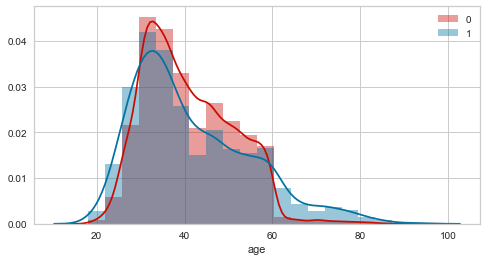

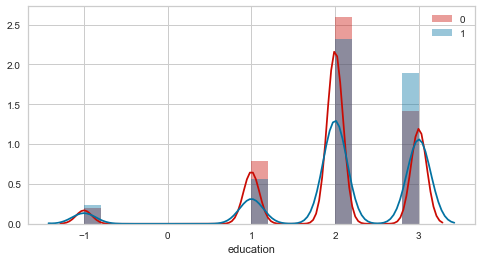

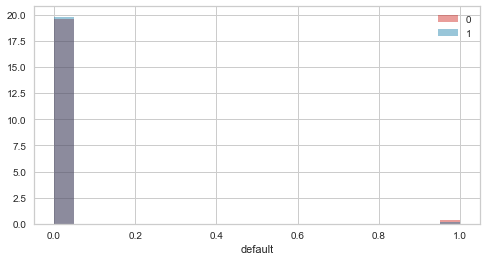

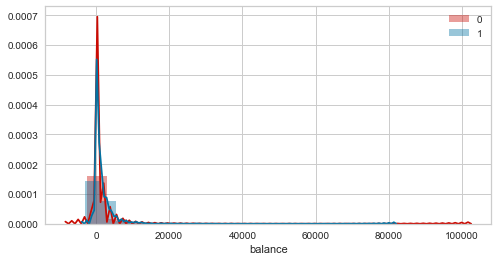

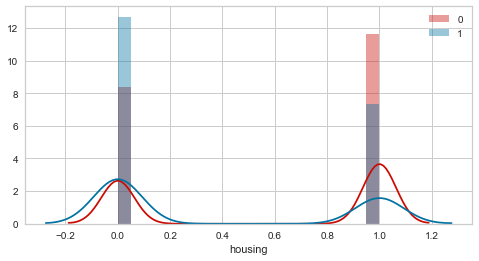

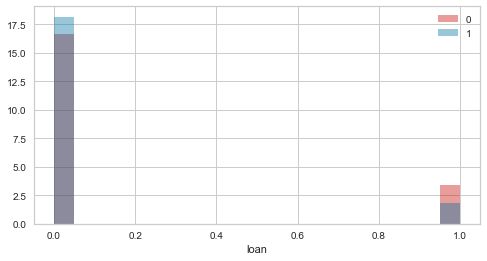

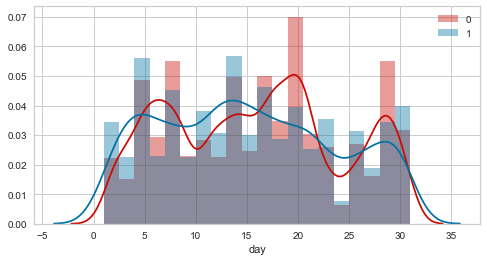

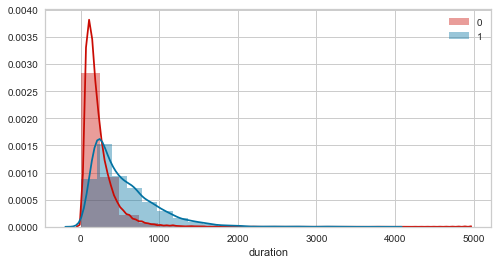

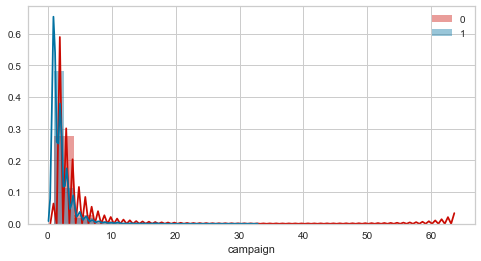

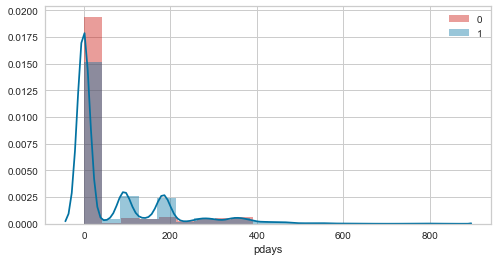

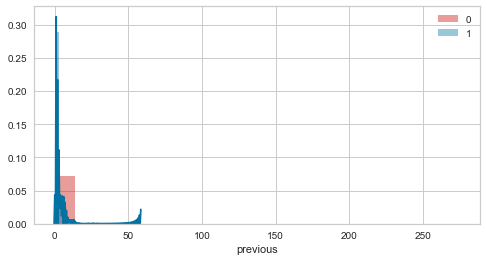

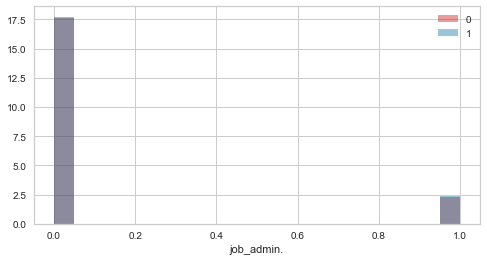

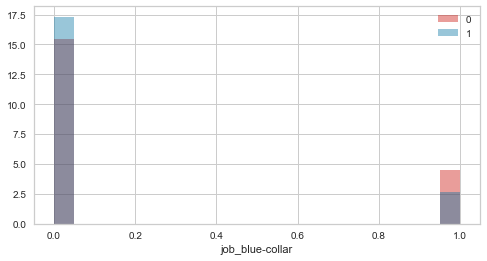

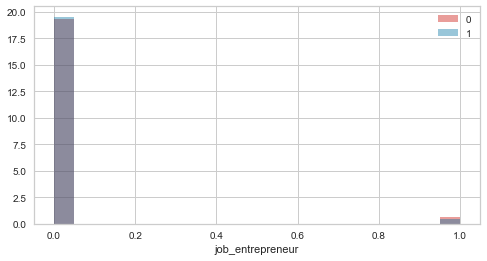

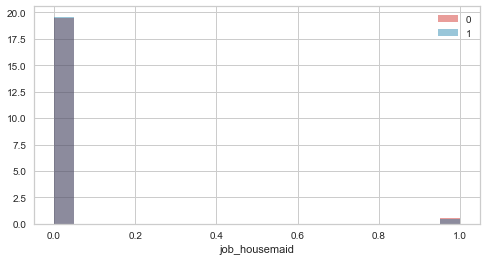

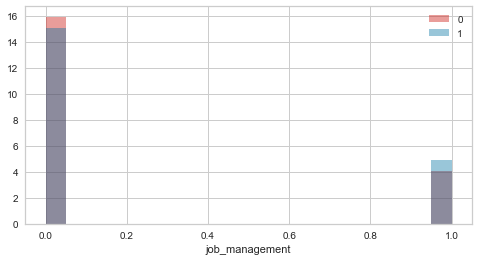

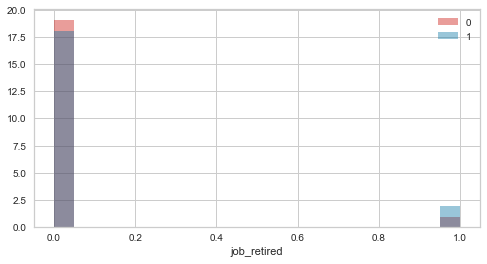

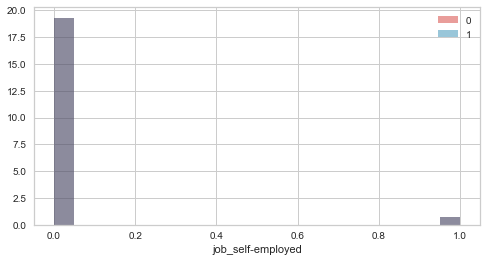

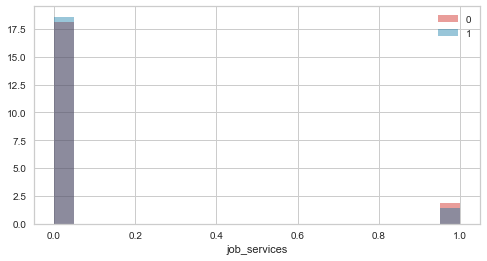

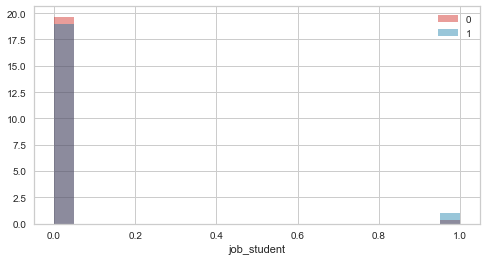

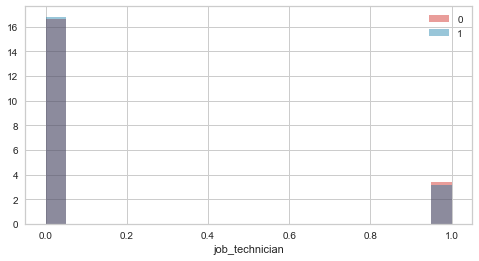

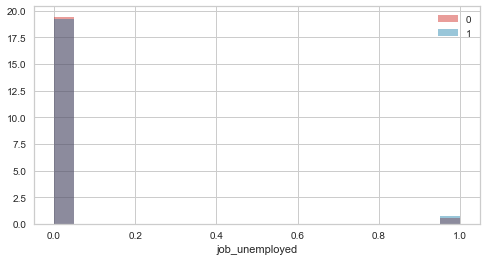

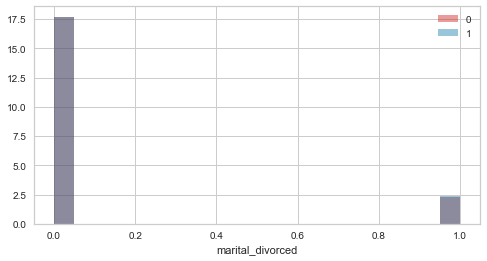

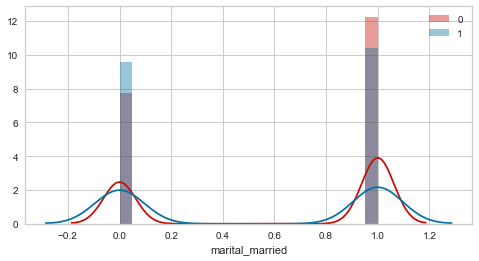

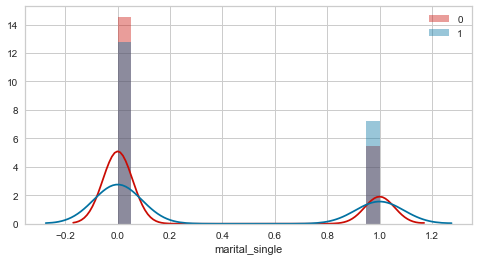

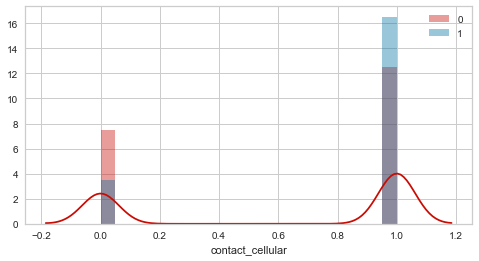

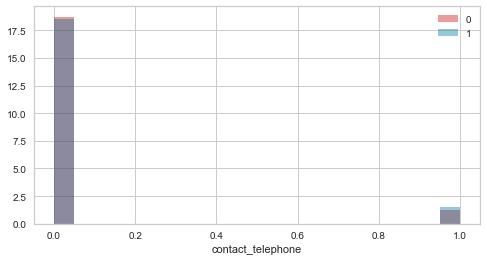

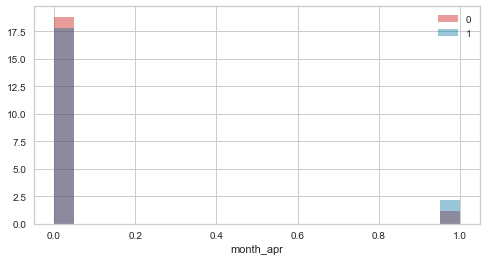

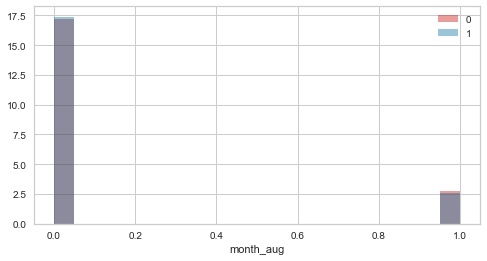

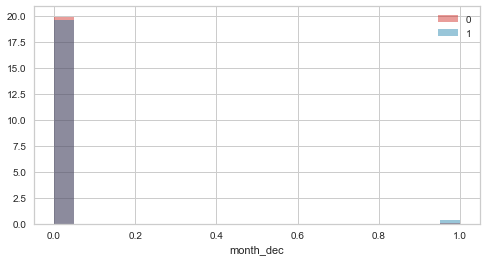

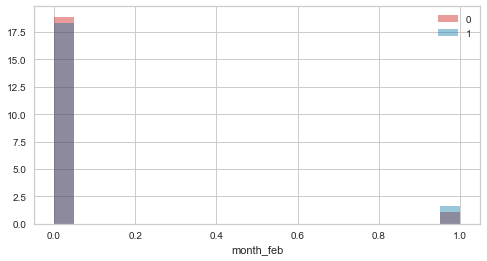

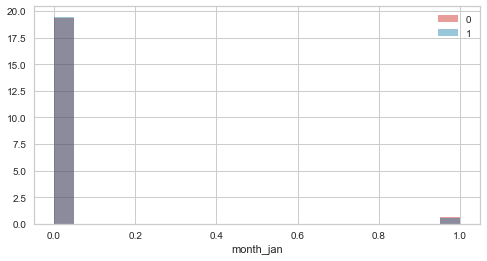

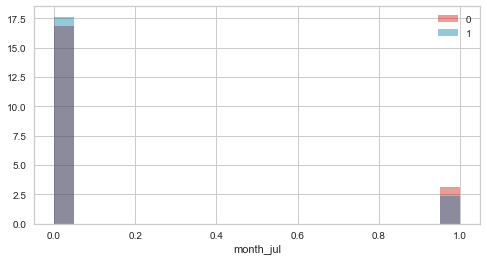

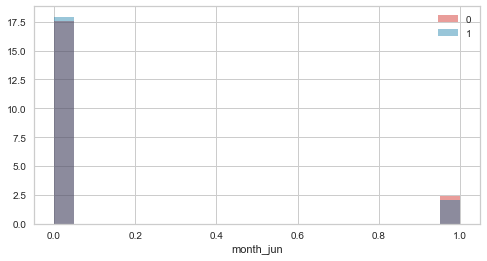

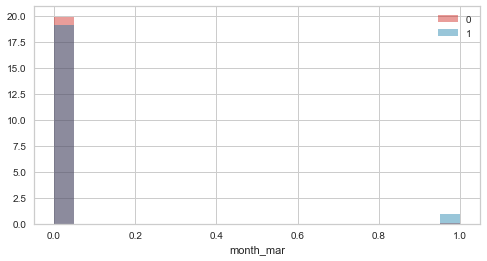

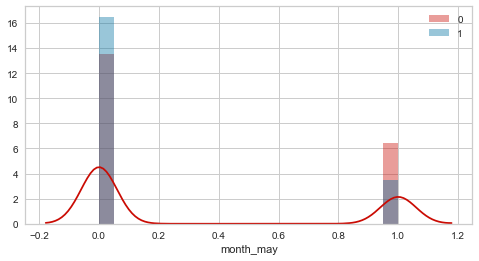

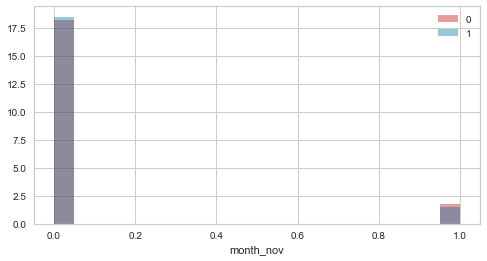

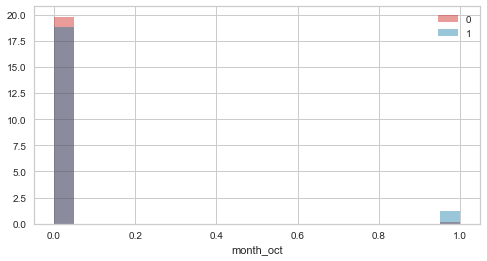

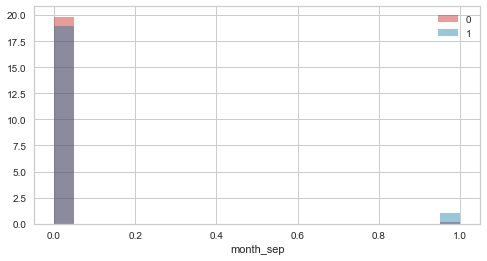

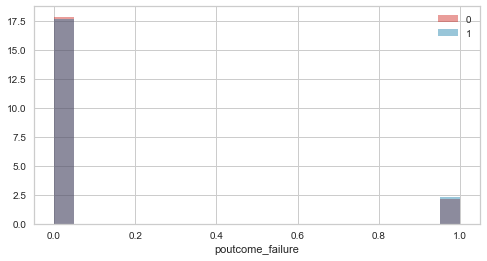

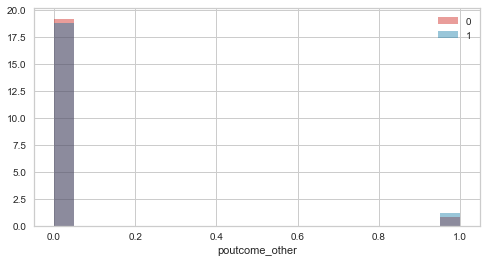

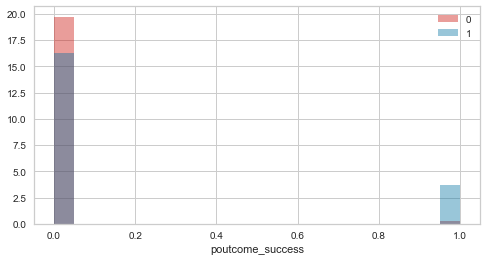

In [294]:
#This is just to visualize the variables distributions
for column in bankDataCooked.columns.drop('Target'):
    sns.distplot(bankDataCooked[bankDataCooked['Target']==0][column],color='r',label=0, bins=20)
    sns.distplot(bankDataCooked[bankDataCooked['Target']==1][column],color='b',label=1, bins=20)
    plt.legend()
    plt.show()

In [295]:
#just a quick analises of direct correlation, I will check better with the gini importance
from sklearn.metrics import matthews_corrcoef

bankPredCorr = {}

for column in bankDataCooked.columns.drop('Target'):
    bankPredCorr[column] = matthews_corrcoef(bankDataCooked[column], bankDataCooked['Target'])
        
sorted(bankPredCorr.items(), key=lambda x: x[1])

[('housing', -0.13917270249816985),
 ('month_may', -0.10249996697156731),
 ('job_blue-collar', -0.07208313870995613),
 ('loan', -0.06818503472421275),
 ('marital_married', -0.06026038456974685),
 ('month_jul', -0.0343815166136324),
 ('job_services', -0.027863949421407144),
 ('default', -0.022418965890751312),
 ('job_entrepreneur', -0.01966230973188168),
 ('month_jun', -0.016804681789821745),
 ('job_housemaid', -0.015194864634455187),
 ('month_nov', -0.014937212152335674),
 ('education', -0.012950253474484951),
 ('job_technician', -0.008969815346243415),
 ('month_jan', -0.0087825531343319),
 ('month_aug', -0.008536282370913735),
 ('age', 0.0),
 ('duration', 5.698845658776996e-06),
 ('pdays', 0.000358667791633214),
 ('job_self-employed', 0.0008550305237868608),
 ('day', 0.0025948779127476966),
 ('marital_divorced', 0.002772367461596446),
 ('balance', 0.005530027043125089),
 ('job_admin.', 0.005637468879356601),
 ('poutcome_failure', 0.0098854530060056),
 ('contact_telephone', 0.014042471

# Preparing the models

In [296]:
X = bankDataCooked.drop('Target' , axis=1)
y = bankDataCooked.pop('Target')

In [297]:
#If I understand right, is 70% Train Data and 30% Test Data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.30, random_state=1)

## Logistic Regression model testing

In [298]:
from sklearn.linear_model import LogisticRegression

In [299]:
lModel = LogisticRegression(random_state=7) 
lModel.fit(xtrain, ytrain)

ypredict = lModel.predict(xtest)

model_score = lModel.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = lModel.score(xtest, ytest)
print('Test accuracy')
print(model_score)

Train accuracy
0.88690871172623

Test accuracy
0.8863167207313477


#### The Training model is slightly better, but 0.88 is a really good score I think

In [300]:
lModel = LogisticRegression(random_state=7, solver="liblinear") 
lModel.fit(xtrain, ytrain)

ypredict = lModel.predict(xtest)

model_score = lModel.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = lModel.score(xtest, ytest)
print('Test accuracy')
print(model_score)

Train accuracy
0.9026448004550194

Test accuracy
0.9015777056915364


#### With the solver="liblinear" the score increased from the default solver

Confusion Matrix


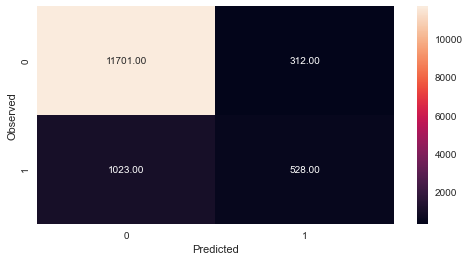

None
Recall
0.3404255319148936

Precision
0.6285714285714286

F1
0.4416562107904642

Roc Auc
0.6572268340503462



In [301]:
def draw_cm( actual, predicted ):
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

print('Recall')
print(str(metrics.recall_score(ytest, ypredict)))
print()

print('Precision')
print(str(metrics.precision_score(ytest, ypredict)))
print()

print('F1')
print(str(metrics.f1_score(ytest, ypredict)))
print()

print('Roc Auc')
print(str(metrics.roc_auc_score(ytest, ypredict)))
print()

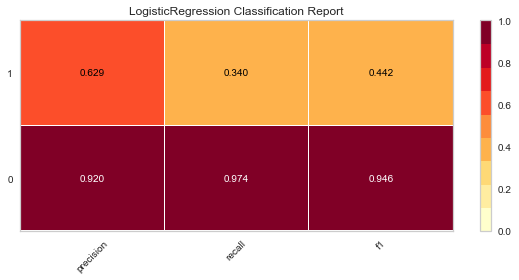

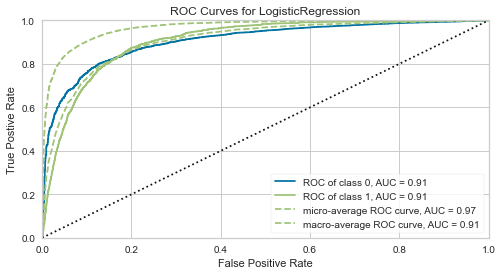

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [302]:
from yellowbrick.classifier import ClassificationReport, ROCAUC
# Visualize model performance with yellowbrick library
viz = ClassificationReport(lModel)
viz.fit(xtrain, ytrain)
viz.score(xtest, ytest)
viz.show()

roc = ROCAUC(lModel)
roc.fit(xtrain, ytrain)
roc.score(xtest, ytest)
roc.show()

## Decision Tree

In [303]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

### Overfit Decision tree

Train accuracy
1.0

Test accuracy
0.8728251253317605
Confusion Matrix


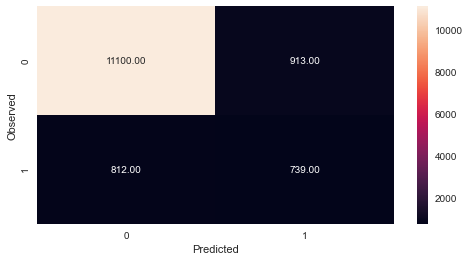

None
Recall
0.4764667956157318

Precision
0.4473365617433414

F1
0.46144239775210744

Roc Auc
0.7002328983489464



In [304]:
model_score = dTree.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = dTree.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = dTree.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

print('Recall')
print(str(metrics.recall_score(ytest, ypredict)))
print()

print('Precision')
print(str(metrics.precision_score(ytest, ypredict)))
print()

print('F1')
print(str(metrics.f1_score(ytest, ypredict)))
print()

print('Roc Auc')
print(str(metrics.roc_auc_score(ytest, ypredict)))
print()

In [305]:
train_char_label = ['No', 'Yes']
overfitTreeFile = open('overfit-tree.dot','w')
dot_data = tree.export_graphviz(dTree, out_file=overfitTreeFile, feature_names = list(xtrain), class_names = list(train_char_label))
overfitTreeFile.close()

retCode = system("dot -Tpng overfit-tree.dot -o overfit-tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("overfit-tree.png"))
    
#This tree is insane...... wow

### Reducing over fit

Train accuracy
0.9014756533004709

Test accuracy
0.90002948982601
Confusion Matrix


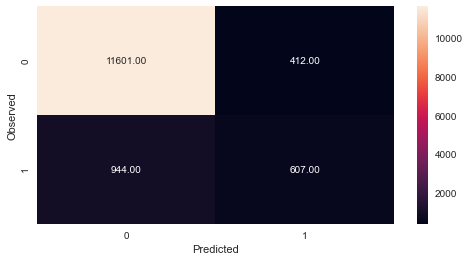

None
Recall
0.3913604126370084

Precision
0.5956820412168793

F1
0.4723735408560311

Roc Auc
0.6785321167488713



In [306]:
# I did tried 4 and 5 depths, but the better overall result still 4 in this case
dTreeR = DecisionTreeClassifier(criterion = 'gini', random_state=1, max_depth = 4)
dTreeR.fit(xtrain, ytrain)

model_score = dTreeR.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = dTreeR.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = dTreeR.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

print('Recall')
print(str(metrics.recall_score(ytest, ypredict)))
print()

print('Precision')
print(str(metrics.precision_score(ytest, ypredict)))
print()

print('F1')
print(str(metrics.f1_score(ytest, ypredict)))
print()

print('Roc Auc')
print(str(metrics.roc_auc_score(ytest, ypredict)))
print()

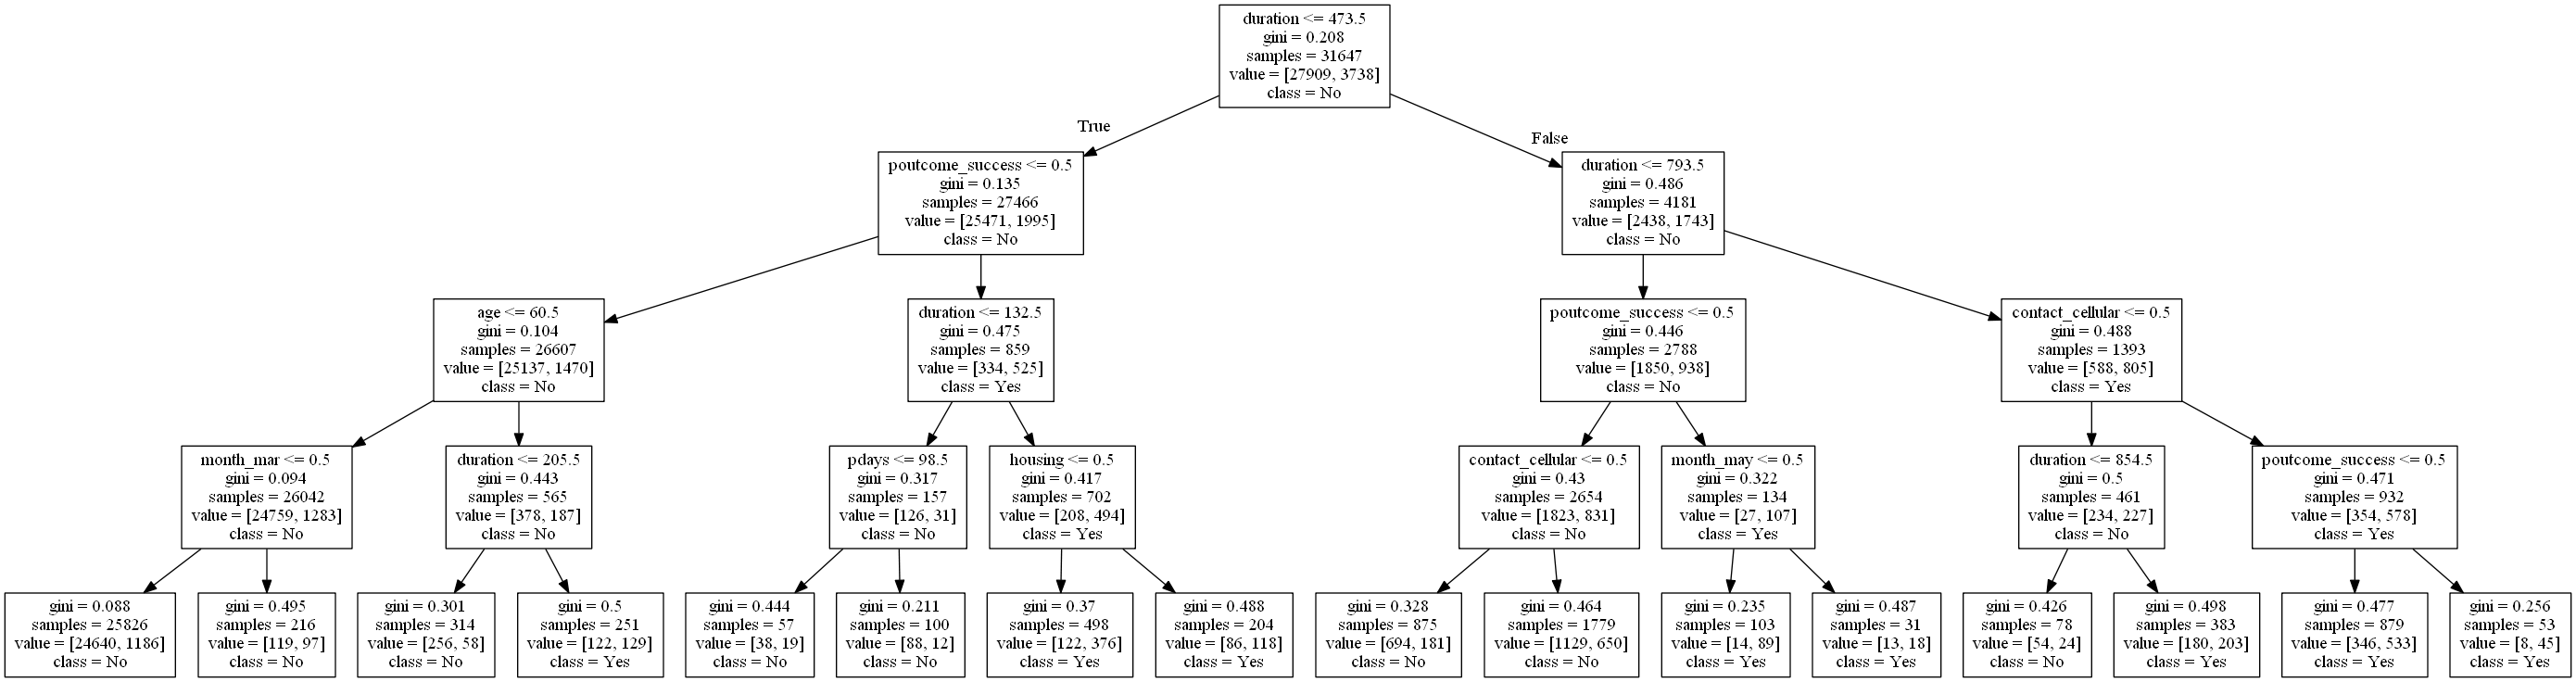

In [307]:
train_char_label = ['No', 'Yes']
regularizedTreeFile = open('regularized-tree.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=regularizedTreeFile, feature_names = list(xtrain), class_names = list(train_char_label))
regularizedTreeFile.close()

retCode = system("dot -Tpng regularized-tree.dot -o regularized-tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("regularized-tree.png"))

### Measuring gini importance

In [308]:
dTreeRImportance = pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = xtrain.columns)
print(dTreeRImportance)

                        Imp
age                0.047082
education          0.000000
default            0.000000
balance            0.000000
housing            0.004842
loan               0.000000
day                0.000000
duration           0.574377
campaign           0.000000
pdays              0.001773
previous           0.000000
job_admin.         0.000000
job_blue-collar    0.000000
job_entrepreneur   0.000000
job_housemaid      0.000000
job_management     0.000000
job_retired        0.000000
job_self-employed  0.000000
job_services       0.000000
job_student        0.000000
job_technician     0.000000
job_unemployed     0.000000
marital_divorced   0.000000
marital_married    0.000000
marital_single     0.000000
contact_cellular   0.021213
contact_telephone  0.000000
month_apr          0.000000
month_aug          0.000000
month_dec          0.000000
month_feb          0.000000
month_jan          0.000000
month_jul          0.000000
month_jun          0.000000
month_mar          0

# Ensembling

In [309]:
#Clearing Data (removing all columns that importance is 0)

bankDataClear = bankDataCooked[dTreeRImportance.loc[dTreeRImportance['Imp'] > 0].transpose().columns]
bankDataClear.describe()

age       housing      duration         pdays  \
count  45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210      0.555838    258.163080     40.197828   
std       10.618762      0.496878    257.527812    100.128746   
min       18.000000      0.000000      0.000000     -1.000000   
25%       33.000000      0.000000    103.000000     -1.000000   
50%       39.000000      1.000000    180.000000     -1.000000   
75%       48.000000      1.000000    319.000000     -1.000000   
max       95.000000      1.000000   4918.000000    871.000000   

       contact_cellular     month_mar     month_may  poutcome_success  
count      45211.000000  45211.000000  45211.000000      45211.000000  
mean           0.647741      0.010551      0.304483          0.033421  
std            0.477680      0.102174      0.460193          0.179735  
min            0.000000      0.000000      0.000000          0.000000  
25%            0.000000      0.000000      0.000000          0.000000  
50%            1.000000      0.000000      0.000000          0.000000  
75%            1.000000      0.000000      1.000000          0.000000  
max            1.000000      1.000000      1.000000          1.000000

In [310]:
X = bankDataClear

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.30, random_state=1)

dTreeR.fit(xtrain, ytrain)
lModel.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [311]:
dfModelsComparision = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision',])

### Bagging Logistic Regression

In [312]:
from sklearn.ensemble import BaggingClassifier

bagModelLR = BaggingClassifier(base_estimator=lModel, n_estimators=50,random_state=1)
bagModelLR = bagModelLR.fit(xtrain, ytrain)

Train accuracy
0.9002117104306885

Test accuracy
0.9017988793866116
Confusion Matrix


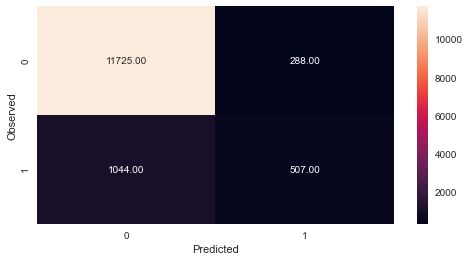

None
Recall
0.32688588007736946

Precision
0.6377358490566037

F1
0.432225063938619

Roc Auc
0.6514559259705919



In [313]:
model_score = bagModelLR.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = bagModelLR.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = bagModelLR.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

rec = metrics.recall_score(ytest, ypredict)
print('Recall')
print(str(rec))
print()

pre = metrics.precision_score(ytest, ypredict)
print('Precision')
print(str(pre))
print()

f1 = metrics.f1_score(ytest, ypredict)
print('F1')
print(str(f1))
print()

roc = metrics.roc_auc_score(ytest, ypredict)
print('Roc Auc')
print(str(roc))
print()

dfModelsComparision = dfModelsComparision.append(pd.Series({'Accuracy': model_score, 'Recall': rec, 'Precision': pre, 'F1': f1,'Roc Auc': roc}, name='Bagging Logic Regression'))

### Bagging Decision Tree

In [314]:
from sklearn.ensemble import BaggingClassifier

bagModelDT = BaggingClassifier(base_estimator=dTreeR, n_estimators=50,random_state=1)
bagModelDT = bagModelDT.fit(xtrain, ytrain)

Train accuracy
0.9011912661547699

Test accuracy
0.903273370687113
Confusion Matrix


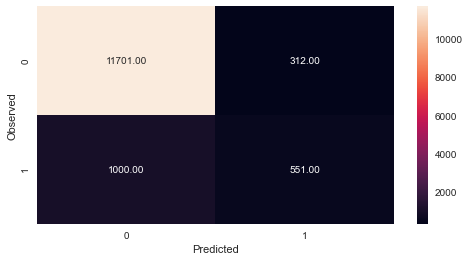

None
Recall
0.3552546744036106

Precision
0.6384704519119351

F1
0.45650372825186414

Roc Auc
0.6646414052947047



In [315]:
model_score = bagModelDT.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = bagModelDT.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = bagModelDT.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

rec = metrics.recall_score(ytest, ypredict)
print('Recall')
print(str(rec))
print()

pre = metrics.precision_score(ytest, ypredict)
print('Precision')
print(str(pre))
print()

f1 = metrics.f1_score(ytest, ypredict)
print('F1')
print(str(f1))
print()

roc = metrics.roc_auc_score(ytest, ypredict)
print('Roc Auc')
print(str(roc))
print()

dfModelsComparision = dfModelsComparision.append(pd.Series({'Accuracy': model_score, 'Recall': rec, 'Precision': pre, 'F1': f1,'Roc Auc': roc}, name='Bagging Decision Tree'))

### Boosting Logic Regression

In [316]:
from sklearn.ensemble import AdaBoostClassifier

#We have now 8 columns, I will choose 6 as a number to create the estimators

boostLR = AdaBoostClassifier(base_estimator=lModel, n_estimators=7, random_state=1)
boostLR = boostLR.fit(xtrain, ytrain)

Train accuracy
0.8888046260309034

Test accuracy
0.8885284576820996
Confusion Matrix


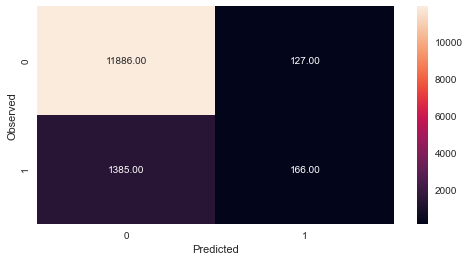

None
Recall
0.10702772404900064

Precision
0.5665529010238908

F1
0.18004338394793926

Roc Auc
0.5482279217930844



In [317]:
model_score = boostLR.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = boostLR.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = boostLR.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

rec = metrics.recall_score(ytest, ypredict)
print('Recall')
print(str(rec))
print()

pre = metrics.precision_score(ytest, ypredict)
print('Precision')
print(str(pre))
print()

f1 = metrics.f1_score(ytest, ypredict)
print('F1')
print(str(f1))
print()

roc = metrics.roc_auc_score(ytest, ypredict)
print('Roc Auc')
print(str(roc))
print()

dfModelsComparision = dfModelsComparision.append(pd.Series({'Accuracy': model_score, 'Recall': rec, 'Precision': pre, 'F1': f1,'Roc Auc': roc}, name='Boosting Logic Regression'))

### Boosting Decision Tree

In [318]:
from sklearn.ensemble import AdaBoostClassifier

boostDT = AdaBoostClassifier(base_estimator=dTreeR, n_estimators=7, random_state=1)
boostDT = boostDT.fit(xtrain, ytrain)

Train accuracy
0.9055518690555187

Test accuracy
0.9013565319964613
Confusion Matrix


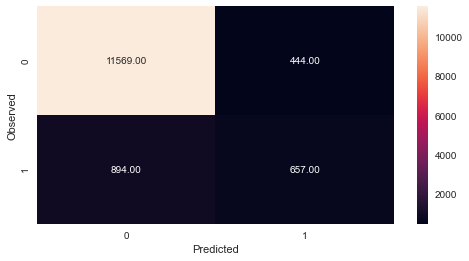

None
Recall
0.42359767891682787

Precision
0.5967302452316077

F1
0.4954751131221719

Roc Auc
0.6933188594367707



In [319]:
model_score = boostDT.score(xtrain, ytrain)
print('Train accuracy')
print(model_score)
print()
model_score = boostDT.score(xtest, ytest)
print('Test accuracy')
print(model_score)

ypredict = boostDT.predict(xtest)

print('Confusion Matrix')
print(draw_cm(ytest,ypredict))

rec = metrics.recall_score(ytest, ypredict)
print('Recall')
print(str(rec))
print()

pre = metrics.precision_score(ytest, ypredict)
print('Precision')
print(str(pre))
print()

f1 = metrics.f1_score(ytest, ypredict)
print('F1')
print(str(f1))
print()

roc = metrics.roc_auc_score(ytest, ypredict)
print('Roc Auc')
print(str(roc))
print()

dfModelsComparision = dfModelsComparision.append(pd.Series({'Accuracy': model_score, 'Recall': rec, 'Precision': pre, 'F1': f1,'Roc Auc': roc}, name='Boosting Decision Tree'))

In [320]:
dfModelsComparision = dfModelsComparision.sort_values(by='Roc Auc')
dfModelsComparision

Accuracy    Recall  Precision        F1   Roc Auc
Boosting Logic Regression  0.888528  0.107028   0.566553  0.180043  0.548228
Bagging Logic Regression   0.901799  0.326886   0.637736  0.432225  0.651456
Bagging Decision Tree      0.903273  0.355255   0.638470  0.456504  0.664641
Boosting Decision Tree     0.901357  0.423598   0.596730  0.495475  0.693319

<AxesSubplot:>

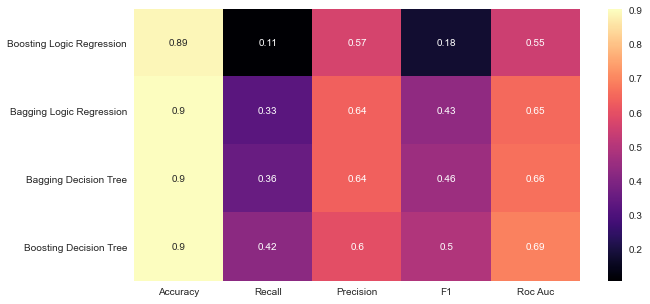

In [321]:
fig,ax = plt.subplots(figsize=(10,5))
sns.heatmap(dfModelsComparision, ax=ax, annot=True, cmap='magma')

# Conclusion

## By Precision both the Bagging models had the best score
## By Recall, F1 and Roc Auc the Boosting Decision Tree had the best scores

## I would choose the Boosting Decision Tree in this case